In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# SDSS loading from Kaggle (local)
df = pd.read_csv("../data/star_classification.csv")

df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [2]:
df.info()
df.describe()
df['class'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

class
GALAXY    59445
STAR      21594
QSO       18961
Name: count, dtype: int64

In [3]:
# Keep only useful columns
useful_cols = ['u', 'g', 'r', 'i', 'z', 'redshift', 'class']
df = df[useful_cols].copy()

# Check missing data
print(df.isna().sum())

# Drop rows with any missing values (should be few)
df = df.dropna()

# Encode target labels to numbers (science kit = sklearn)
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['class_encoded'] = encoder.fit_transform(df['class'])

print(encoder.classes_)
df.head()

u           0
g           0
r           0
i           0
z           0
redshift    0
class       0
dtype: int64
['GALAXY' 'QSO' 'STAR']


,u,g,r,i,z,redshift,class,class_encoded
0,23.87882,22.27530,20.39501,19.16573,18.79371,0.634794,GALAXY,0
1,24.77759,22.83188,22.58444,21.16812,21.61427,0.779136,GALAXY,0
2,25.26307,22.66389,20.60976,19.34857,18.94827,0.644195,GALAXY,0
3,22.13682,23.77656,21.61162,20.50454,19.25010,0.932346,GALAXY,0
4,19.43718,17.58028,16.49747,15.97711,15.54461,0.116123,GALAXY,0


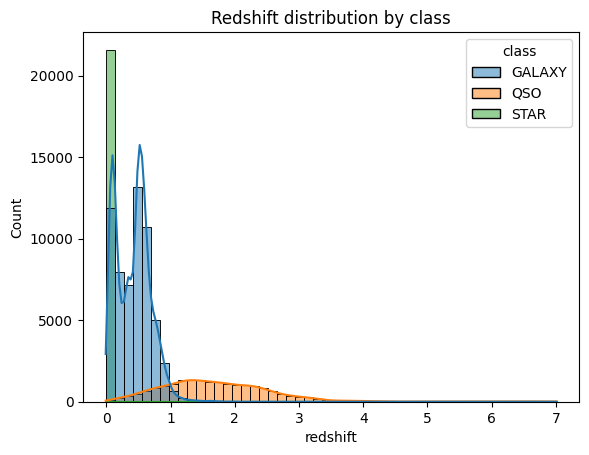

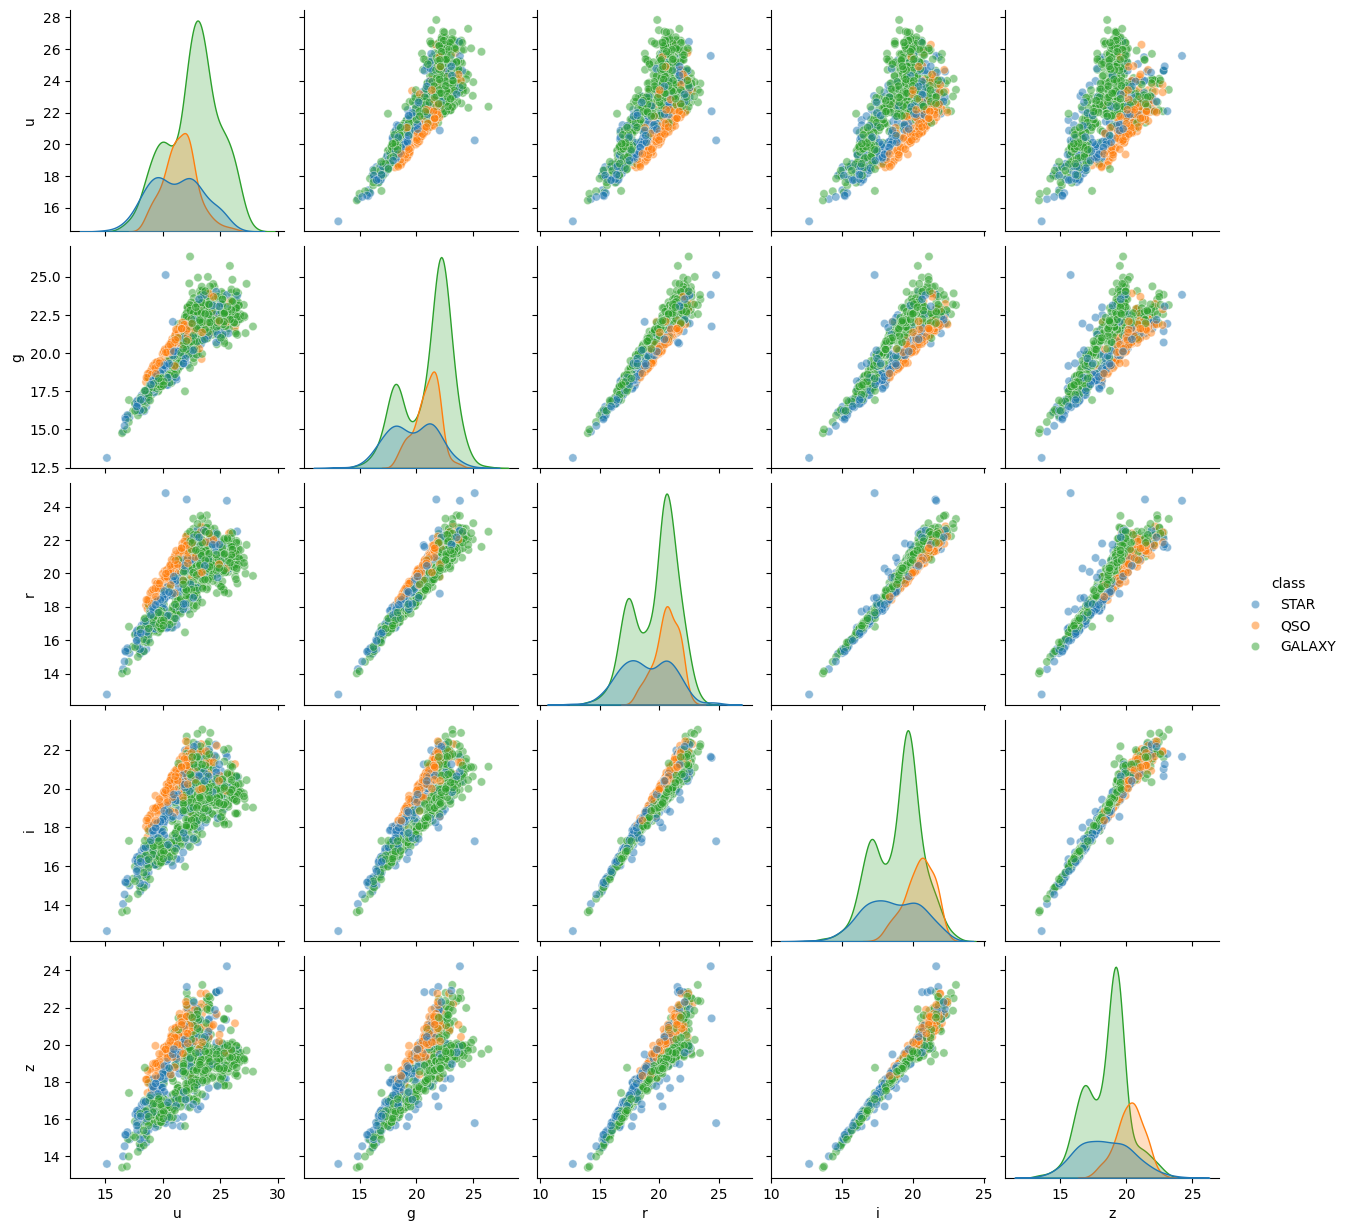

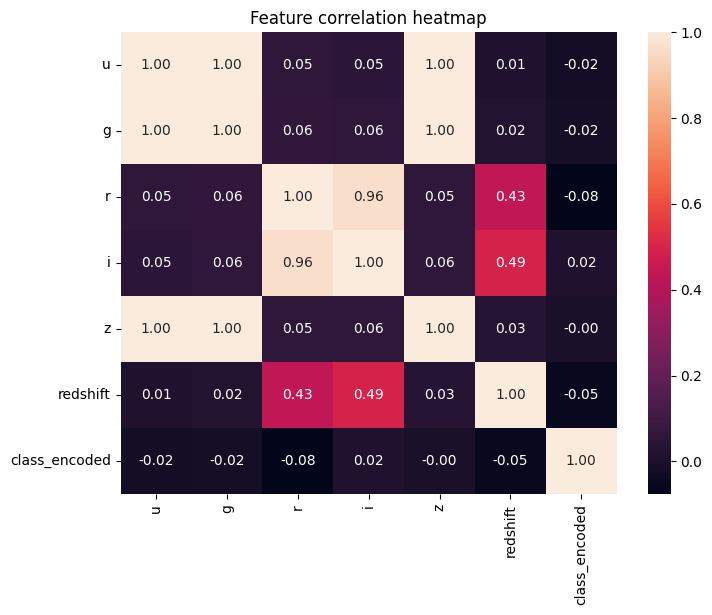

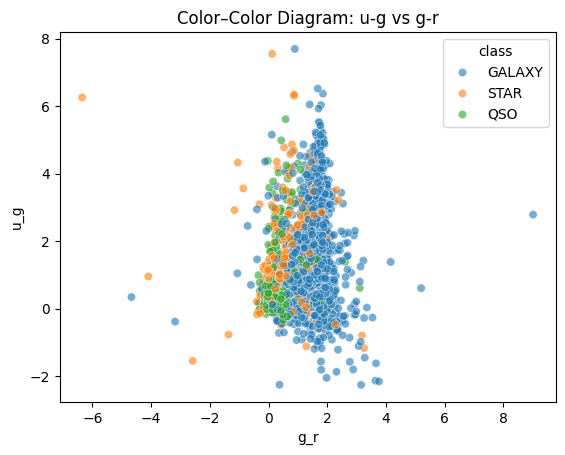

In [ ]:
# Exploratory Data Analysis (EDA)
# How do features relate to the class ?

import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of redshift per class
sns.histplot(data=df, x='redshift', hue='class', bins=50, kde=True)
plt.title('Redshift distribution by class')
plt.show()

# Pairplot between magnitudes (takes a bit of time to render)
sns.pairplot(df.sample(1000), vars=['u','g','r','i','z'], hue='class', plot_kws={'alpha':0.5})
plt.show()

# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df[['u','g','r','i','z','redshift','class_encoded']].corr(), annot=True, fmt='.2f')
plt.title('Feature correlation heatmap')
plt.show()

# Create color indices
df['u_g'] = df['u'] - df['g']
df['g_r'] = df['g'] - df['r']
df['r_i'] = df['r'] - df['i']
df['i_z'] = df['i'] - df['z']

# Check result
df[['u_g', 'g_r', 'r_i', 'i_z']].describe()

# Visualize classes colors
sns.scatterplot(data=df.sample(3000), x='g_r', y='u_g', hue='class', alpha=0.6)
plt.title('Color–Color Diagram: u-g vs g-r')
plt.show()

              precision    recall  f1-score   support

      GALAXY       0.98      0.99      0.98     11889
         QSO       0.97      0.93      0.95      3792
        STAR       0.99      1.00      1.00      4319

    accuracy                           0.98     20000
   macro avg       0.98      0.97      0.98     20000
weighted avg       0.98      0.98      0.98     20000



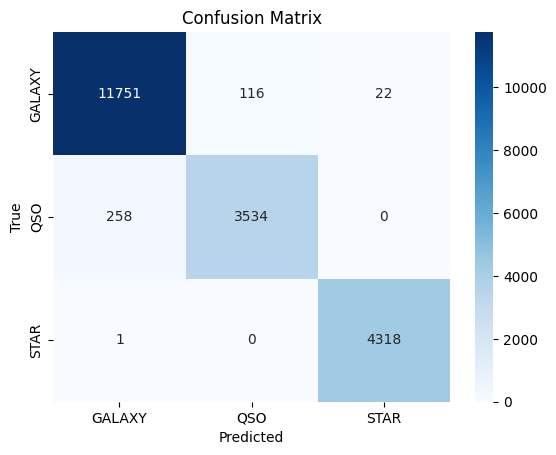

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Features and target
features = ['u', 'g', 'r', 'i', 'z', 'redshift', 'u_g', 'g_r', 'r_i', 'i_z']
X = df[features]
y = df['class_encoded']   # ✅ correct name

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train model
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=df['class'].unique()))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=df['class'].unique(),
            yticklabels=df['class'].unique())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

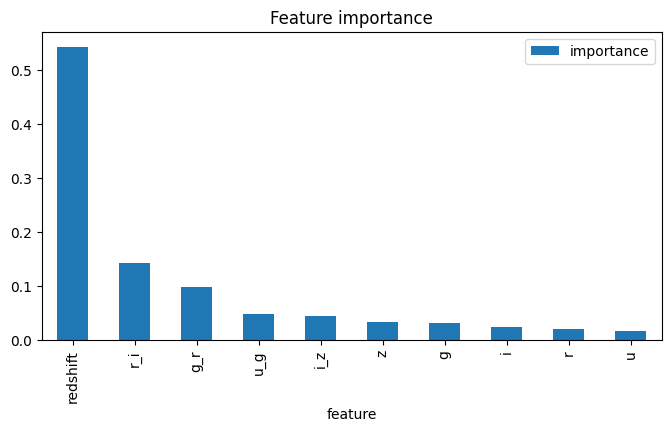

In [6]:
# Evaluation and model insight
import pandas as pd

importances = model.feature_importances_
feature_names = X.columns

fi = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

fi.plot(kind='bar', x='feature', y='importance', figsize=(8,4))
plt.title("Feature importance")
plt.show()

In [7]:
import joblib

joblib.dump(model, "stellar_classifier.pkl")
print("Model saved")

Model saved


In [8]:
joblib.dump(encoder, "label_encoder.pkl")

['label_encoder.pkl']

In [10]:
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier(
    n_estimators=50,
    random_state=42,
    n_jobs=-1 # use all CPU cores
)

scores = cross_val_score(rf, X, y, cv=3, scoring='f1_macro')
print("CV F1 (macro):", scores.mean(), "+/-", scores.std())

CV F1 (macro): 0.9755696907062106 +/- 0.0002684378176380325


              precision    recall  f1-score   support

      GALAXY       0.98      0.99      0.98     11889
         QSO       0.97      0.93      0.95      3792
        STAR       0.99      1.00      1.00      4319

    accuracy                           0.98     20000
   macro avg       0.98      0.97      0.98     20000
weighted avg       0.98      0.98      0.98     20000



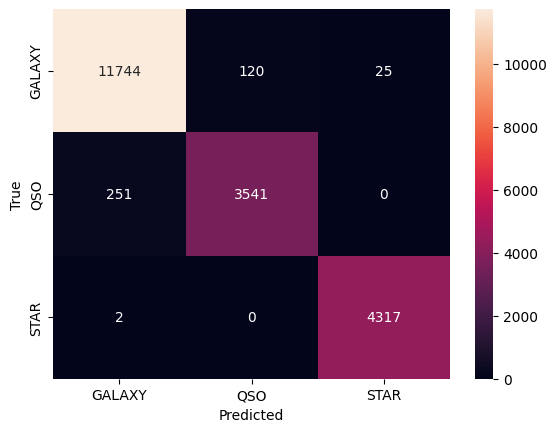

In [12]:
# Confusion matrix and per-class report
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=encoder.classes_))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [13]:
# SKIP: class weight balancing
rf = RandomForestClassifier(
    n_estimators=150,
    random_state=42,
    n_jobs=1,
    class_weight="balanced"
)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=encoder.classes_))

              precision    recall  f1-score   support

      GALAXY       0.98      0.99      0.98     11889
         QSO       0.97      0.93      0.95      3792
        STAR       1.00      1.00      1.00      4319

    accuracy                           0.98     20000
   macro avg       0.98      0.97      0.98     20000
weighted avg       0.98      0.98      0.98     20000



In [15]:
# Create color indices
df["u_g"] = df["u"] - df["g"]
df["g_r"] = df["g"] - df["r"]
df["r_i"] = df["r"] - df["i"]
df["i_z"] = df["i"] - df["z"]

features = ["u","g","r","i","z","redshift","u_g","g_r","r_i","i_z"]

X = df[features]
print(X.columns)
y = df["class_encoded"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

rf = RandomForestClassifier(
    n_estimators=150,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=encoder.classes_))

Index(['u', 'g', 'r', 'i', 'z', 'redshift', 'u_g', 'g_r', 'r_i', 'i_z'], dtype='object')
              precision    recall  f1-score   support

      GALAXY       0.98      0.99      0.98     11889
         QSO       0.97      0.93      0.95      3792
        STAR       0.99      1.00      1.00      4319

    accuracy                           0.98     20000
   macro avg       0.98      0.97      0.98     20000
weighted avg       0.98      0.98      0.98     20000



In [16]:
from sklearn.ensemble import HistGradientBoostingClassifier

gb = HistGradientBoostingClassifier(
    learning_rate=0.1,
    max_depth=8,
    max_iter=300,
    random_state=42
)

gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

print(classification_report(y_test, y_pred_gb, target_names=encoder.classes_))

              precision    recall  f1-score   support

      GALAXY       0.98      0.99      0.98     11889
         QSO       0.97      0.93      0.95      3792
        STAR       0.99      1.00      0.99      4319

    accuracy                           0.98     20000
   macro avg       0.98      0.97      0.98     20000
weighted avg       0.98      0.98      0.98     20000

